In [12]:
import numpy as np
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from skpsl import ProbabilisticScoringList

from experiments.util import DataLoader

# fit psl and get a instance of the calibrator


In [13]:
X, y = DataLoader("./experiments/data").load("thorax")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 3, random_state=10)
pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy="most_frequent"),
    ProbabilisticScoringList({1, 2, 3}).fit(X, y),
)

In [14]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(missing_values=-1, strategy='most_frequent')),
                ('probabilisticscoringlist',
                 ProbabilisticScoringList(score_set={1, 2, 3}))])

In [15]:
from sklearn.metrics import confusion_matrix

def conservative_weighted_loss(y_true, y_prob, m=10, *, sample_weight=None):
    if y_prob.shape[1] == 3:
        lb, _, ub = y_prob.T
    else:
        ub = y_prob[:,1]
    tn, fp, fn, tp = confusion_matrix(y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all", labels=[False,True]).ravel()
    print(confusion_matrix(y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all", labels=[False,True]))

    return fp + m * fn


In [16]:
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

In [17]:
psl_short = psl[:6]

In [18]:
import networkx as nx


def create_dag(psl):
    dag = nx.DiGraph()
    for stage, (first, second) in enumerate(zip(psl, psl[1:])):
        tscores = first.class_counts_per_score.keys() 
        score = second.scores[-1]
        for tscore in tscores:
            first_neg = first.class_counts_per_score[tscore][0]
            first_pos = first.class_counts_per_score[tscore][1]
            first_proba = first.calibrator.transform(np.array([tscore])).item()
            second_0_neg = second.class_counts_per_score[tscore][0]
            second_0_pos = second.class_counts_per_score[tscore][1]
            second_0_proba = second.calibrator.transform(np.array([tscore])).item()
            second_1_neg = second.class_counts_per_score[tscore+score][0]
            second_1_pos = second.class_counts_per_score[tscore+score][1]
            second_1_proba = second.calibrator.transform(np.array([tscore+score])).item()
            
            dag.add_node((stage,tscore), num_neg = first_neg, num_pos = first_pos, proba = first_proba)
            dag.add_node((stage+1,tscore), num_neg = second_0_neg, num_pos = second_0_pos, proba = second_0_proba)
            dag.add_node((stage+1,tscore+score),num_neg = second_1_neg, num_pos = second_1_pos, proba = second_1_proba)
            # case 1: Feature ist not active
            dag.add_edge((stage,tscore),(stage+1,tscore),score=0)
            # case 1: Feature ist active
            dag.add_edge((stage,tscore),(stage+1,tscore+score),score=score)
    return dag

In [19]:
psl.inspect(k=3)

,Stage,Feature Index,Score,T = 0,T = 2,T = 3,T = 5,T = 6,T = 8
0,0,NaN,NaN,0.152691,NaN,NaN,NaN,NaN,NaN
1,1,5.0,3.0,0.085008,NaN,0.440789,NaN,NaN,NaN
2,2,8.0,3.0,0.027907,NaN,0.111349,NaN,0.547009,NaN
3,3,2.0,2.0,0.022222,0.030488,0.030488,0.205479,0.533333,0.54902


{((0, 0),
  (1, 0)): Text(0.5000011393567547, -4.440892098500626e-16, "{'score': 0}"),
 ((0, 0),
  (1, 3)): Text(0.5000107613159344, 1.5000322839478035, "{'score': 3}"),
 ((1, 0),
  (2, 0)): Text(1.5000011393567547, -4.440892098500626e-16, "{'score': 0}"),
 ((1, 0),
  (2, 3)): Text(1.5000107613159344, 1.5000322839478035, "{'score': 3}"),
 ((1, 3),
  (2, 3)): Text(1.5000011393567547, 3.0000000000000004, "{'score': 0}"),
 ((1, 3), (2, 6)): Text(1.5000107613159344, 4.500032283947803, "{'score': 3}"),
 ((2, 0),
  (3, 0)): Text(2.5000011393567547, -4.440892098500626e-16, "{'score': 0}"),
 ((2, 0),
  (3, 2)): Text(2.5000023253960535, 1.0000046507921065, "{'score': 2}"),
 ((2, 3),
  (3, 3)): Text(2.5000011393567547, 3.0000000000000004, "{'score': 0}"),
 ((2, 3), (3, 5)): Text(2.5000023253960535, 4.000004650792107, "{'score': 2}"),
 ((2, 6), (3, 6)): Text(2.5000011393567547, 6.0, "{'score': 0}"),
 ((2, 6), (3, 8)): Text(2.5000023253960535, 7.000004650792105, "{'score': 2}"),
 ((3, 0),
  (4, 0)

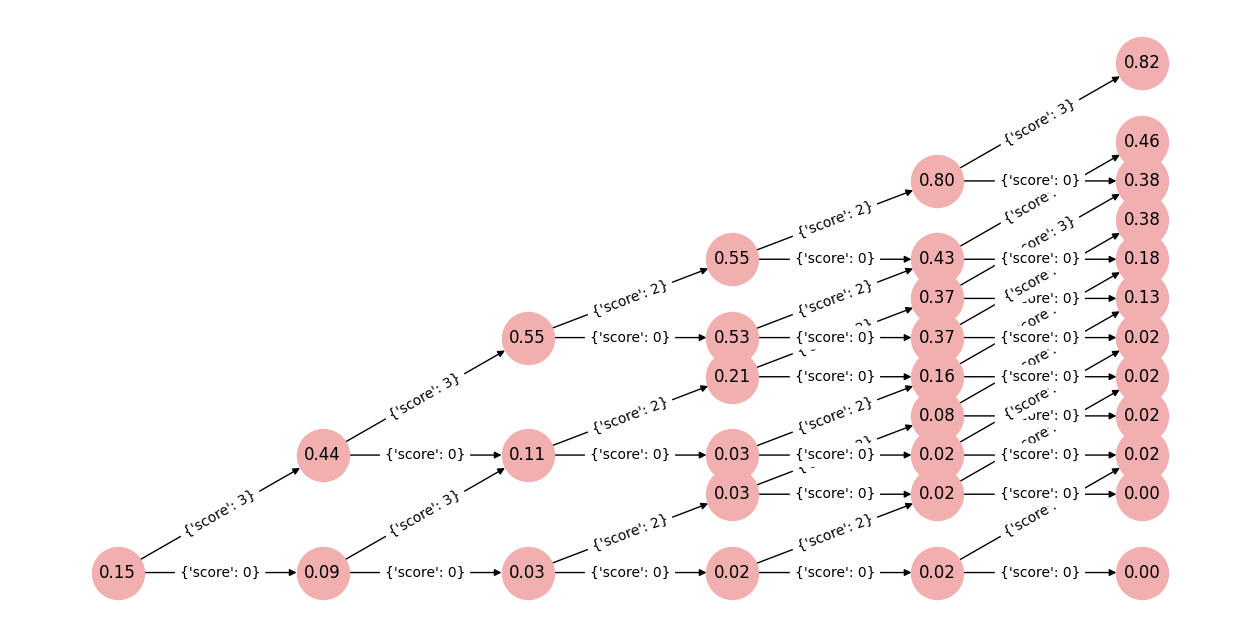

In [21]:
from matplotlib import figure

dag = create_dag(psl_short)
pos = {x:x for x in dag.nodes}
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
node_labels = {
    node: f"{dag.nodes[node]['proba']:.2f}"
    for node in dag.nodes}
nx.draw(dag, pos, with_labels = False,ax=ax, node_size=1400, node_color="#F1AFAF")
nx.draw_networkx_labels(dag, pos, node_labels)
nx.draw_networkx_edge_labels(dag,pos=pos)

In [10]:
from scipy.stats import entropy
from collections import defaultdict
import numpy as np

def expected_loss(y_prob,m=10):
    ub = y_prob[:,1].item()
    y_decision = 1 - ub < m * ub
    loss = (1 - ub) * 1 if y_decision else ub * 10
    return loss

def calculate_evois(dag, loss=expected_loss, weight_by_bucket_size=False):
    evois = {}
    for node in dag.nodes:

        proba = dag.nodes[node]["proba"]
        current_loss = loss(np.array([[1-proba, proba]]))

        children = dag.successors(node)
        successors = nx.single_source_shortest_path_length(dag, node)
        # largest_dist = max(successors.values())
        largest_dist=1
        node_evois = {}
        for dist in range(1,largest_dist+1):
            succs_at_dist = [k for k,v in successors.items() if int(v) == dist]
            succ_losses, weights = [], []
            for succ in succs_at_dist:
                succ_losses.append(loss(np.array([[1-dag.nodes[succ]["proba"], dag.nodes[succ]["proba"]]])))
                if weight_by_bucket_size:
                    weights.append(dag.nodes[succ]["num_pos"] + dag.nodes[succ]["num_neg"])
                else:
                    weights.append(1)
            
            if succ_losses:
                succ_losses, weights = np.array(succ_losses), np.array(weights)
                expected_loss_reduction = np.average(np.full_like(succ_losses, current_loss) - succ_losses, weights = weights)
                node_evois[dist] = expected_loss_reduction / dist
        evois[node] = node_evois
    evois = defaultdict(dict,evois)
    return evois
calculate_evois(dag)


defaultdict(dict,
            {(0, 0): {1: 0.1426652333862785},
             (1, 0): {1: 0.26621691423305927},
             (1, 3): {1: -0.1116106819786522},
             (2, 0): {1: 0.015519631940505443},
             (2, 3): {1: 0.33895166523458375},
             (2, 6): {1: -0.005832076420311749},
             (3, 0): {},
             (3, 2): {},
             (3, 3): {},
             (3, 5): {},
             (3, 6): {},
             (3, 8): {}})

In [11]:
per_instance_budget = 3
ci = 0.5
overall_budget = per_instance_budget * len(y_test)
voi = 0.05
# Predictions when always evaluation the same amount of features per instance
y_prob_non_adaptive = pipeline.predict_proba(X_test, k=per_instance_budget, ci=ci)


# Instantiate dag for heuristic
dag = create_dag(psl=psl)
evois = calculate_evois(dag)
y_prob_adaptive = []
remaining_budget = overall_budget
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

for x_test in X_test:
    x_test = x_test.reshape(1,-1)    
    stage = 0
    current_score = int(psl[stage]._compute_total_scores(
            x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
        ).item())
    current_proba = psl.predict_proba(x_test, k=stage, ci=ci)[0]

    while any(evoi >= voi for evoi in evois[(stage,current_score)].values()) and remaining_budget - stage > 0:
        stage += 1
        current_score = psl[stage]._compute_total_scores(
                x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
            ).item()
        current_proba = psl.predict_proba(x_test, k=stage, ci=ci)[0]
    
    remaining_budget -= stage

    y_prob_adaptive.append(current_proba)
y_prob_adaptive = np.stack(y_prob_adaptive)

In [219]:
cwloss_adap = conservative_weighted_loss(y_test, y_prob_adaptive)
cwloss_non_adap = conservative_weighted_loss(y_test, y_prob_non_adaptive)


[[0.515  0.34  ]
 [0.0225 0.1225]]
[[0.545 0.31 ]
 [0.03  0.115]]


In [221]:
print("non adaptive:", cwloss_non_adap)
print("adaptive:", cwloss_adap)

non adaptive: 0.61
adaptive: 0.565


In [247]:
import pandas as pd
df = pd.read_csv("experiments/results/cost_results.csv")

In [248]:
df

,Unnamed: 0,method,seed,per_instance_budget,overall_budget,score_set,ci,voi,cwloss,remaining_budget,tp,fp,fn,tn
0,0,adaptive,0,3,1200,"{1, 2, 3}",0.5,0.05,0.4575,0,43,153,3,201
1,1,baseline,0,3,1200,"{1, 2, 3}",0.5,0.05,0.6850,0,45,264,1,90
2,2,adaptive,1,3,1200,"{1, 2, 3}",0.5,0.05,0.6025,0,60,121,12,207
3,3,baseline,1,3,1200,"{1, 2, 3}",0.5,0.05,0.6600,0,70,244,2,84
4,4,adaptive,2,3,1200,"{1, 2, 3}",0.5,0.05,0.8775,400,47,91,26,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,baseline,97,3,1200,"{1, 2, 3}",0.5,0.05,0.4675,0,62,177,1,160
196,196,adaptive,98,3,1200,"{1, 2, 3}",0.5,0.05,0.4975,0,57,179,2,162
197,197,baseline,98,3,1200,"{1, 2, 3}",0.5,0.05,0.5100,0,58,194,1,147
198,198,adaptive,99,3,1200,"{1, 2, 3}",0.5,0.05,0.5250,0,54,120,9,217


<Axes: xlabel='method', ylabel='cwloss'>

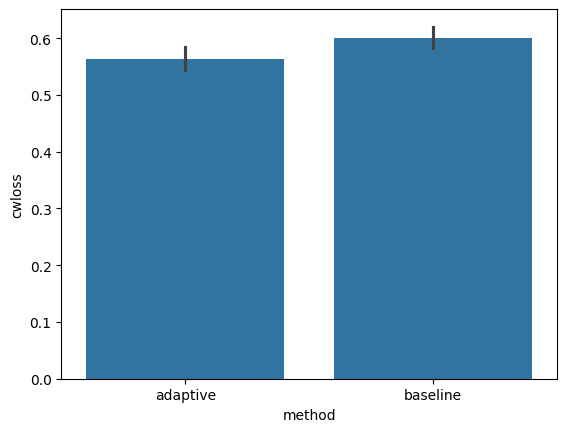

In [250]:
sns.barplot(df,x="method", y="cwloss")

<Axes: xlabel='method', ylabel='cwloss'>

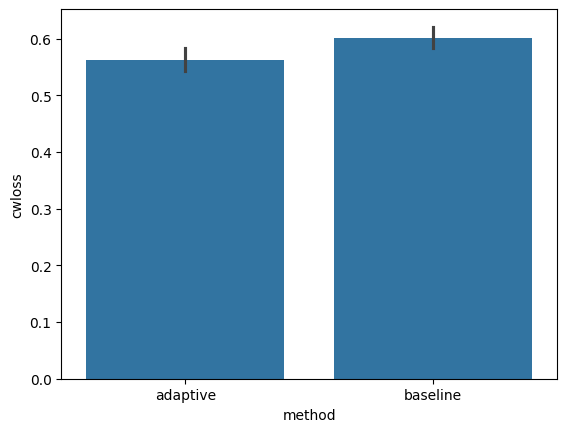

In [258]:
sns.barplot(df,x="method", y="cwloss")